<a href="https://colab.research.google.com/github/rodseidel/mpca/blob/master/IA_w13_Rodrigo_Seidel_project_learning_problema1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema 1

O projeto consiste em usar o algoritmo de clusterização K-Means para agrupar imagens. Para isso, será utilizada a base de dados Yale Face que contém fotos de pessoas em diferentes expressões faciais.
**Serão utilizadas as imagens das expressões "happy", "normal", "sad", "sleepy", and "surprised". As expressões das fotos estão descritas no final dos nomes dos arquivos.**
A figura 1 traz exemplos das imagens da base. **Cada linha corresponde a um indivíduo e cada coluna uma expressão.**
Note que as pessoas nem sempre estão no centro das imagens e que existe um grande espaço vazio ao redor dos rostos. Queremos agrupar as imagens considerando características dorosto, então **as imagens devem ser pré-processadas para remover o espaço vazio e centralizar as faces
nas imagens**. As etapas de pré-processamento são descritas abaixo e na figura 2. A figura 3 ilustra imagens após o pré-processamento.
1. O detector de faces da OpenCV deve ser usado para identificar um retângulo que define a posição da face na imagem. O retângulo retornado costuma ser mais largo e um pouco mais alto que as faces. Então, ele deve ser reduzido em 20% na esquerda, na direita e no topo.
2. Equalização de histograma é utilizado para evitar que a iluminação e o tom de pele dos indivíduos sejam usados como critério predominante do agrupamento.
3. Redução do tamanho da imagem (resize) para 50x50 para que reduzir o custo computacional.
4. O algoritmo K-Means recebe como entrada vetores e não matrizes, então as imagens devem ser transformadas nesse formato.

* **Após executar o algoritmo K-Means, o programa deve mostrar o número de faces e 5 faces aleatórias de cada cluster.** 
* **Adicione um parágrafo explicando como o algoritmo K-Means funciona, e outro descrevendo qual critério você acha que o algoritmo usou para agrupar as imagens.** Elas foram agrupadas por indivíduos? Por expressão facial? Ou por alguma característica da face? Dica: Tenha em mente que a distância entre as imagens é dada pela **raiz quadrada da soma da diferença entre as cores
dos pixels elevada ao quadrado**.

Recursos:
* Base de dados Yale Face: http://vision.ucsd.edu/content/yale-face-database .
* Documentação do Algoritmo K-Means na biblioteca scikit-learn:
> * https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
> * https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
* Processamento de Imagens
> * Detecção de faces:
https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81 .
Observação: o algoritmo retorna uma lista contendo as faces da imagem. Ele
pode retornar mais de uma detecção mesmo que existe apenas uma face na
imagem. Vocês devem escolher o retângulo de maior área na lista.
> * Equalização de histograma (função cv2.equalizeHist):
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html.
> * Transformação de matriz em vetor:
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html.
* * Como ler as imagens do disco (provavelmente existe uma forma melhor de fazer isso):

#Imports e download arquivos externos

In [ ]:
pip install opencv-python

In [ ]:
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os
import zipfile
import shutil
import os
import PIL
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
#DOWNLOAD THE TRAINED CLASSIFIER XML FILE
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2020-09-13 21:00:41--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2020-09-13 21:00:42 (14.7 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [ ]:
#DOWNLOAD DATASET FROM KAGGLE
os.environ['KAGGLE_USERNAME'] = "xxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxxxxx" # key from the json file
!kaggle datasets download -d olgabelitskaya/yale-face-database

yale-face-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#UNZIP FILE
zf = zipfile.ZipFile('yale-face-database.zip')
zf.extractall()

#Funções

In [ ]:
#FUNCTIONS
def convert_PIL2cv(image):
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  #Monocromático
        pass
    elif new_image.shape[2] == 3:  #Colorido
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

def load_img(path): 
  new_path = path + ".gif"
  shutil.copyfile(path, new_path)
  img = PIL.Image.open(new_path)
  img = convert_PIL2cv(img)
  os.remove(new_path)
  return img

In [ ]:
def face_detection(image):
  # Load the cascade
  face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

  # Read the input image
  img = load_img(image)#'/content/subject01.happy')

  # Detect faces
  faces = face_cascade.detectMultiScale(img, 1.03, 5)

  # Draw rectangle around the faces
  for (x, y, w, h) in faces:
      #Redução de 20%, esquerda, direita e topo
      x_red = int(x + h*0.2)
      y_red = int(y + w*0.2)
      w_red = int(w*0.8 - (y_red - y))
      h_red = int(h*0.8)
      #x_red = int(x*1.2)
      #y_red = int(y*1.2)
      #w_red = int(w*0.8)
      #h_red = int(h*1)
     
#/content/subject01.happy
#x = 101
#y = 56
#w = 157
#h = 157
#start - top left corner (x,y)
#end   - botton right corner (x+w,y+h)
      cv2.rectangle(img, (x_red, y_red), (x_red + w_red, y_red + h_red), (54, 54, 54), 2)
      croped_img = img[y_red:y_red+h_red, x_red:x_red+w_red]

  # Display the output
  #cv2_imshow(img)
  #cv2.waitKey()
  return img, croped_img

#Seleção imagens da lista de arquivos

In [ ]:
#SELEÇÃO DAS IMAGENS QUE SERÃO TRABALHADAS
#SOMENTE happy, normal, sad, sleepy e surprised
imageFiles = [f for f in os.listdir('/content') if f.endswith('.happy') or \
f.endswith('.normal') or f.endswith('.sad') or f.endswith('.sleepy') or f.endswith('.surprised')]

#Redução de 20% retângulo face e crop

In [ ]:
#Lista com as imagens com os quadros destacados com 20% redução e cropadas (direita/esquerda e superior)
images = []
croped_images = []
for img in imageFiles:
  fd = face_detection('/content/' + img)
  images.append(fd[0])
  croped_images.append(fd[1])

#Equalização histograma e resize 50x50

In [ ]:
#Equalização de histograma e resize - 50x50
imagesEqualizedResized = []
for img in croped_images:
  equalized = cv2.equalizeHist(img)
  equalized_resized = cv2.resize(equalized, (50,50), interpolation = cv2.INTER_AREA)
  imagesEqualizedResized.append(equalized_resized)
  #cv2_imshow(equ_resized)

#Transformações

In [ ]:
#Transformação cada imagem de matriz em vetor
images_array = []

for i in imagesEqualizedResized:
  images_array.append(np.reshape(i, 50*50))

In [ ]:
#Convert to pandas dataset
images_dataset = pd.DataFrame(images_array)

#Clusterização K-Means

In [ ]:
#KMEANS
#init parameter: kmeans++ method. 
#max_iter parameter: the maximum number of iterations there can be to find the final clusters when the 
#  K-meands algorithm is running. we #enter the default value of 300
#n_init parameter: the number of times the #K_means algorithm will be run with different initial centroid.

kmeans = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=42 )
# Fitting the input data
kmeans = kmeans.fit(images_dataset)
# Getting the cluster labels: returns for each observation which cluster it belongs to
y_kmeans = kmeans.predict(images_dataset)

In [ ]:
y_kmeans_dataset = pd.DataFrame(y_kmeans, columns=['cluster'])

In [ ]:
c1 = y_kmeans_dataset[y_kmeans_dataset["cluster"]==0]
c1_examples = c1.sample(5)

c2 = y_kmeans_dataset[y_kmeans_dataset["cluster"]==1]
c2_examples = c2.sample(5)

c3 = y_kmeans_dataset[y_kmeans_dataset["cluster"]==2]
c3_examples = c3.sample(5)

c4 = y_kmeans_dataset[y_kmeans_dataset["cluster"]==3]
c4_examples = c4.sample(5)

c5 = y_kmeans_dataset[y_kmeans_dataset["cluster"]==4]
c5_examples = c5.sample(5)

#Cluster 1

Quantidade faces cluster 1: 14
Exemplos:


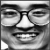

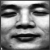

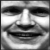

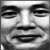

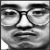

In [ ]:
#Quantity and examples
print("Quantidade faces cluster 1: " + str(len(c1)))

print("Exemplos:")

for i in range(0,5):
  cv2_imshow(imagesEqualizedResized[c1_examples.index[i]])

#Cluster 2

Quantidade faces cluster 2: 10
Exemplos:


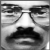

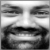

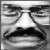

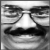

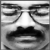

In [ ]:
#Quantity and examples
print("Quantidade faces cluster 2: " + str(len(c2)))

print("Exemplos:")

for i in range(0,5):
  cv2_imshow(imagesEqualizedResized[c2_examples.index[i]])

#Cluster 3

Quantidade faces cluster 3: 16
Exemplos:


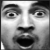

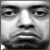

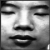

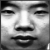

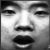

In [ ]:
#Quantity and examples
print("Quantidade faces cluster 3: " + str(len(c3)))

print("Exemplos:")

for i in range(0,5):
  cv2_imshow(imagesEqualizedResized[c3_examples.index[i]])

#Cluster 4

Quantidade faces cluster 4: 5
Exemplos:


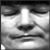

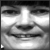

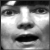

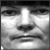

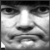

In [ ]:
#Quantity and examples
print("Quantidade faces cluster 4: " + str(len(c4)))

print("Exemplos:")

for i in range(0,5):
  cv2_imshow(imagesEqualizedResized[c4_examples.index[i]])

#Cluster 5

Quantidade faces cluster 5: 30
Exemplos:


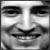

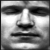

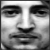

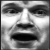

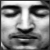

In [ ]:
#Quantity and examples
print("Quantidade faces cluster 5: " + str(len(c5)))

print("Exemplos:")

for i in range(0,5):
  cv2_imshow(imagesEqualizedResized[c5_examples.index[i]])

#Como o algoritmo K-Means funciona?

A criação de grupos de pontos, imagens, etc chama-se clusterização.

O k-means realiza o agrupamento atribuindo rótulos para cada item de uma quantidade K de grupos. Nesse algoritmo, a forma como esses grupos são definidos é realizando a criação de centróides para cada grupo. Os centróides são o ponto central do grupo e a partir deles são identificados os itens mais próximos a ele e, em seguida, adicionados aquele grupo.

Este processo ocorre através dos seguintes passos:

1. Definir do K centroids.
2. Encontrar o centróide mais próximo e atualizar os rótulos de cada ponto. A métrica utilizada para se medir a distância é um hiperparâmetro e podem ser várias. Ex.: distância Euclidiana.
3. Mover os centróides para o centro de seus clusters. As novas posições de cada centróide é calculada como a posição média de cada um dos pontos no cluster.
4. Repetir os passos 2 e 3 até o centróide parar de se mover muito, ou seja, até o algoritmo convergir.

#Qual critério você acha que o algoritmo usou para agrupar as imagens?

As imagens não foram agrupadas por indivíduos ou por expressão facial. 

A partir do momento que transformamos a imagem numa matriz de 50 x 50 pixels, e em seguida transformamos essa matriz em um vetor, passamos a ter um registro para cada imagem e com cada imagem contendo 2500 features. Foram utilizadas essas features para realizar a clusterização, ou seja, as imagens que tinham pixels mais "semelhantes", ou seja, pertencentes a um cluster, conforme descrito em como o K-Means funciona, foram rotuladas pentencendo a dos 5 clusters.

Isso é possível observar no clustes 1 (ao menos na execução no momento que escrevi esse texto) que as faces continham a região da boca/queixo mais escuras (por conta de bigode ou barba).

Já no cluster 2 (ao menos na execução no momento que escrevi esse texto) observamos que as faces continham a parte inferior da face limpa (sem barba/bigode) porém, continham grande presença de cabelo na testa (parte superior escura).

No cluster 3 (ao menos na execução no momento que escrevi esse texto) podemos observar a região dos olhos mais escura, seja pela presença de óculos ou por existir uma sobrancelha bem marcante.

No cluster 4 (ao menos na execução no momento que escrevi esse texto) com podemos observar as imagens com o nariz mais evidente e a região das bochechas mais destacadas.